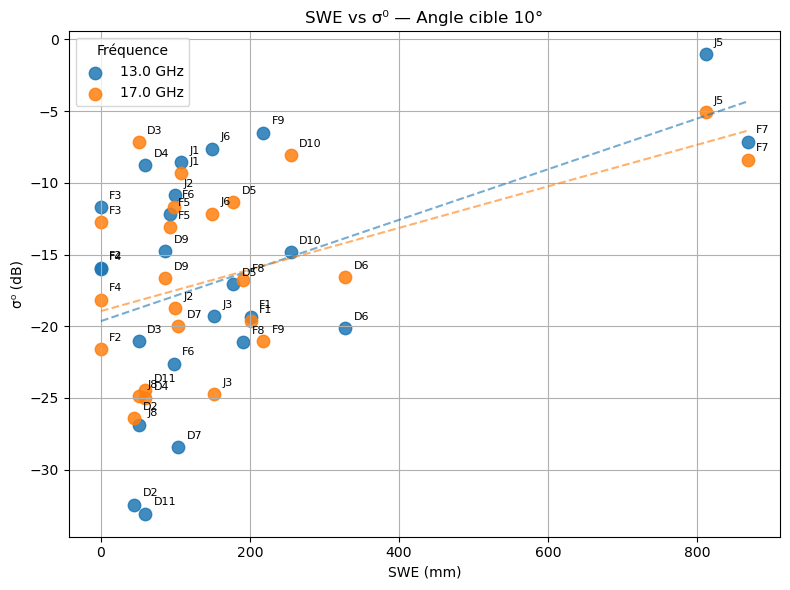

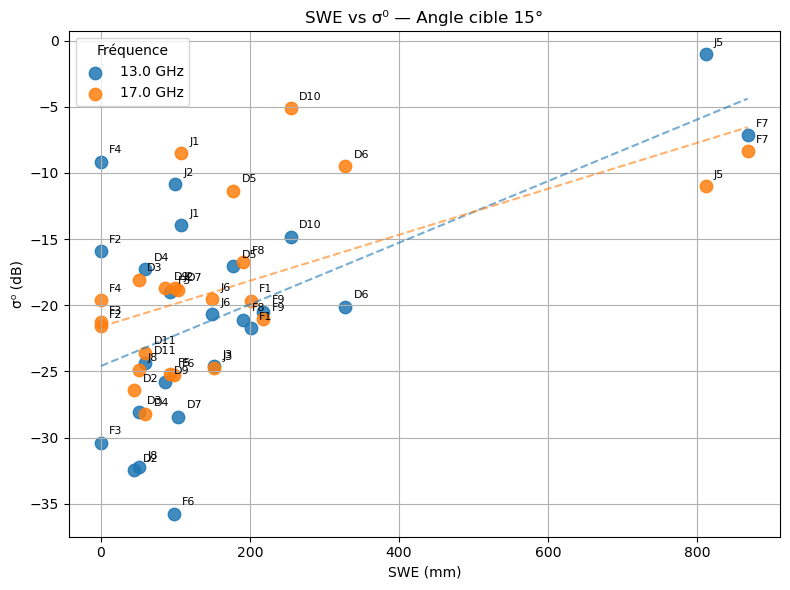

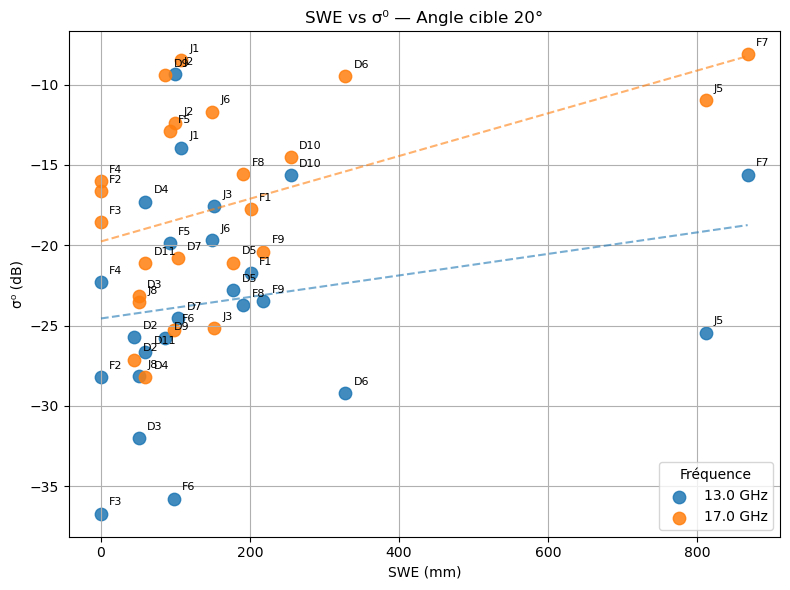

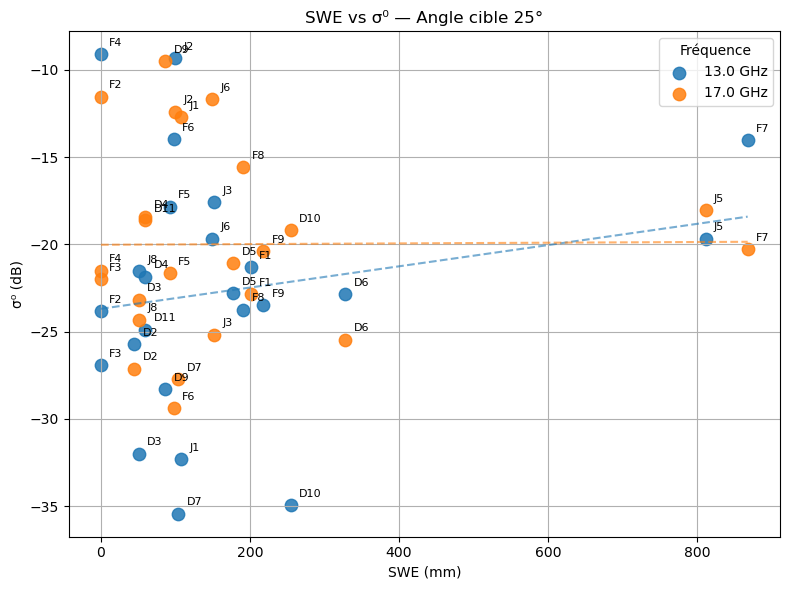

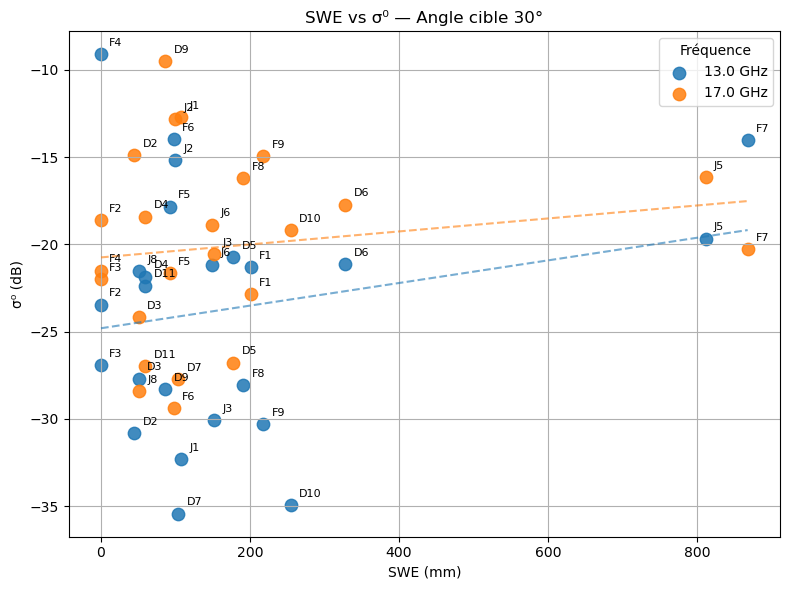

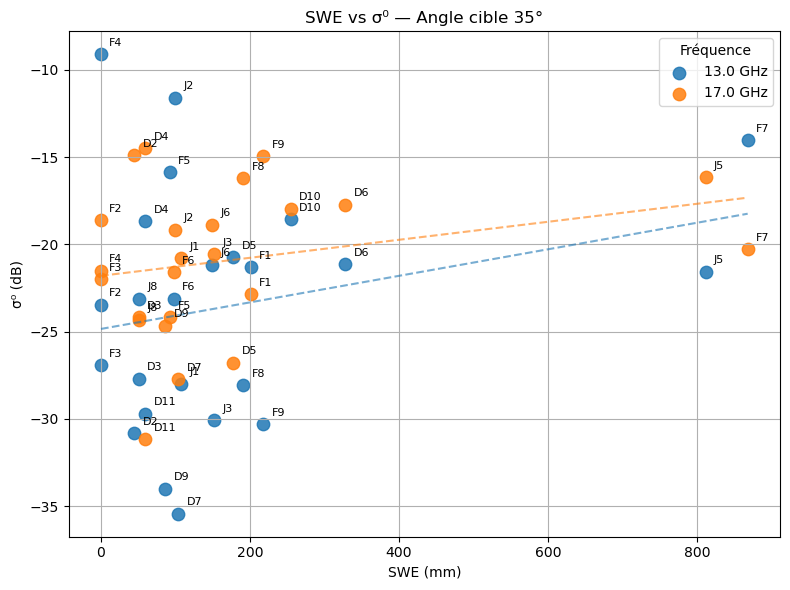

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# === 1. Charger le tableau de SWE ===
swe_df = pd.read_csv('../data/metadata/swe_summary.csv')

# === 2. Charger les fichiers sigma0_raw ===
sigma_files = glob.glob('../results/sigma0_raw_*.csv')

records = []

for file in sigma_files:
    df = pd.read_csv(file)
    pit_id = os.path.basename(file).replace("sigma0_raw_", "").replace(".csv", "")
    df['pit_id'] = pit_id
    records.append(df)

sigma_df = pd.concat(records, ignore_index=True)

# === 3. Fusion SWE + sigma0 ===
merged = pd.merge(swe_df, sigma_df, on='pit_id', how='inner')

# === 4. Angles cibles ===
angles_cibles = [10,15,20,25,30,35]

# === 5. UN GRAPH PAR ANGLE, avec 13 et 17 superposés ===
for angle_cible in angles_cibles:

    plt.figure(figsize=(8, 6))

    for freq in sorted(merged['frequence'].unique()):  # 13 puis 17

        df_freq = merged[merged['frequence'] == freq]

        df_angle = (
            df_freq
            .assign(angle_diff=lambda d: np.abs(d['angle_vue_reel'] - angle_cible))
            .sort_values('angle_diff')
            .groupby('pit_id')
            .first()
            .reset_index()
        )

        # --- scatter ---
        plt.scatter(df_angle['SWE_mm'], df_angle['sigma0'],
                    label=f"{freq} GHz",
                    s=80, alpha=0.85)

        # --- annotations PIT ID ---
        for _, row in df_angle.iterrows():
            plt.annotate(
                row['pit_id'],
                (row['SWE_mm'], row['sigma0']),
                textcoords="offset points",
                xytext=(6, 6),
                fontsize=8
            )

        # --- ligne de regression ---
        if len(df_angle) > 2:
            m, b = np.polyfit(df_angle['SWE_mm'], df_angle['sigma0'], 1)
            xfit = np.linspace(df_angle['SWE_mm'].min(),
                               df_angle['SWE_mm'].max(), 100)
            plt.plot(xfit, m*xfit + b, '--', alpha=0.6)

    # --- mise en forme ---
    plt.title(f"SWE vs σ⁰ — Angle cible {angle_cible}°")
    plt.xlabel("SWE (mm)")
    plt.ylabel("σ⁰ (dB)")
    plt.grid(True)
    plt.legend(title="Fréquence")
    plt.tight_layout()
    plt.show()
